In [95]:
import torch
import kagglehub
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import cm
from torch import nn, optim
from __future__ import annotations
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output

import warnings

In [96]:
import os
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

# Create a .kaggle directory and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [97]:
path = kagglehub.dataset_download("bloodlaac/products-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/bloodlaac/products-dataset/versions/2


In [98]:
warnings.filterwarnings("ignore")

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [100]:
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

In [101]:
criterion = nn.CrossEntropyLoss()

In [102]:
food_dir = Path(f"{path}/products_dataset")

FOOD_CLASSES = ['Fresh', 'Bad']

In [103]:
class LabeledDataset():
    def __init__(
        self,
        food_dir: Path,
        food_classes: list[str],
        transform=None) -> LabeledDataset:

        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = Path(food_dir)
            class_path /= cls_name

            for image_name in class_path.iterdir():
                image_path = class_path / image_name
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))

    def __len__(self) -> int:
        return len(self.images_paths)

    def __getitem__(self, index: int):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [104]:
train_transforms = T.Compose([
    T.Resize(int(IMAGE_SIZE * 1.14)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    T.ToTensor(),
    T.Normalize(IMAGE_MEAN, IMAGE_STD),
])

In [105]:
eval_transforms = T.Compose([
    T.Resize(int(IMAGE_SIZE * 1.14)),
    T.ToTensor(),
    T.CenterCrop(IMAGE_SIZE),
    T.Normalize(IMAGE_MEAN, IMAGE_STD),
])

In [106]:
food_dataset = LabeledDataset(food_dir, FOOD_CLASSES)

In [107]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    food_dataset, [0.6, 0.2, 0.2]
)

In [108]:
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = eval_transforms
test_dataset.dataset.transform = eval_transforms

In [109]:
train_dataloader = DataLoader(
  train_dataset,
  batch_size=16,
  shuffle=True,
  num_workers=4,
  pin_memory=True
)

In [110]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [111]:
class Block(nn.Module):
    """
    Create basic unit of ResNet.

    Consists of two convolutional layers.

    """

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            downsampling=None
        ) -> Block:

        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,  # TODO: Replace with padding="same"
            padding=1
        )
        self.downsampling = downsampling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input = x

        pred = self.bn1(self.conv1(x))
        pred = self.relu(pred)
        pred = self.bn2(self.conv2(pred))

        if self.downsampling is not None:
            input = self.downsampling(x)

        pred += input
        pred = self.relu(pred)

        return pred

In [112]:
class ResNet(nn.Module):
    """
    Build model ResNet and return prediction

    """

    def __init__(self, blocks_num_list: list[int]) -> ResNet:
        """
        ResNet init.

        Parameters
        ----------
        blocks_num_list : list[int]
                          Number of basic blocks for each layer.

        """
        super().__init__()

        self.in_channels = 64  # Default number of channels for first layer. Mutable!

        # Reduce resolution of picture by 2
        # 224 -> 112
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 -> 56

        self.layer1 = self.create_layer(  # Default stride. No resolution reduction.
            out_channels=64,
            num_blocks=blocks_num_list[0]
        )
        self.layer2 = self.create_layer(  # Resolution reduction. 56 -> 28
            out_channels=128,
            num_blocks=blocks_num_list[1],
            stride=2
        )
        self.layer3 = self.create_layer(  # Resolution reduction. 28 -> 14
            out_channels=256,
            num_blocks=blocks_num_list[2],
            stride=2
        )
        self.layer4 = self.create_layer(  # Resolution reduction. 14 -> 7
            out_channels=512,
            num_blocks=blocks_num_list[3],
            stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 20)

    def create_layer(
            self,
            out_channels: int,
            num_blocks: int,
            stride: int = 1
        ) -> nn.Sequential:
        """
        Create ResNet layer.

        Parameters
        ----------
        out_channels : int
            Number of output channels per block
        num_blocks : int
            Number of blocks per layer
        stride : int, default=1
            Step of filter in conv layer

        """
        downsampling = None

        if stride != 1:
            downsampling = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )

        blocks: list[Block] = []

        blocks.append(Block(
            in_channels=self.in_channels,
            out_channels=out_channels,
            stride=stride,
            downsampling=downsampling
        ))

        self.in_channels = out_channels

        for _ in range(num_blocks - 1):
            blocks.append(Block(out_channels, out_channels))

        return nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.pooling(pred)

        pred = self.layer1(pred)
        pred = self.layer2(pred)
        pred = self.layer3(pred)
        pred = self.layer4(pred)

        pred = self.avgpool(pred)
        pred = torch.flatten(pred, 1)
        pred = self.fc(pred)

        return pred

In [113]:
def plot_history(
        epochs: int,
        train_history: list,
        val_history: list,
        optimizer_name: str,
        label: str
    ):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.plot(np.arange(1, epochs + 1), train_history, label=label)
    ax2.plot(np.arange(1, epochs + 1), val_history, label=label)

    for ax in (ax1, ax2):
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower right')
        ax.grid(True)

    ax1.set_title(f'{optimizer_name} Training accuracy')
    ax2.set_title(f'{optimizer_name} Validation accuracy')

    plt.tight_layout()
    plt.show()

In [114]:
def validate(model, loader, criterion):
    correct, total = 0, 0
    val_loss = 0.0

    model.eval()

    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        loss = criterion(pred, labels)
        val_loss += loss.item() * len(labels)
        total += len(labels)

        pred = torch.argmax(pred, dim=1)

        correct += (pred == labels).sum().item()

    accuracy = correct / total
    loss = val_loss / total

    return accuracy, loss

In [115]:
def train(model, criterion, train_loader, val_loader, optimizer, epochs=10):
    train_acc, train_loss = [], []
    validation_acc, validation_loss = [], []

    model.train()

    for epoch in tqdm(range(epochs), leave=False):
        correct, total = 0, 0
        epoch_loss = 0.0

        for i, batch in enumerate(train_loader, start=1):
            images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)

            loss.backward()
            optimizer.step()

            pred = torch.argmax(pred, dim=1)

            total += len(labels)
            epoch_loss += loss.item() * pred.shape[0]
            correct += (pred == labels).sum().item()
            accuracy = correct / total

            if i % 100 == 0:
              temp_loss = epoch_loss / total

              print(f"Epoch: [{epoch + 1}/{epochs}], Step: [{i}/{len(train_loader)}]\n"
                    f"Train loss: {temp_loss:.4f}, Train Accuracy: {accuracy:.4f}\n")

        train_acc.append(accuracy)
        train_loss.append(epoch_loss / total)
        val_acc, val_loss = validate(model, val_loader, criterion)
        validation_acc.append(val_acc)
        validation_loss.append(val_loss)

        print(f"Epoch: [{epoch}/{epochs}] has passed\n"
              f"Train loss: {train_loss[-1]:.4f}, Train accuracy: {train_acc[-1]:.4f}\n"
              f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}\n")

    return train_acc, train_loss, validation_acc, validation_loss

In [116]:
def test(model, loader, criterion):
    correct, total = 0, 0
    test_loss = 0.0

    y_true, y_pred = [], []

    model.eval()

    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        loss = criterion(pred, labels)
        test_loss += loss.item() * len(labels)

        pred = torch.argmax(pred, dim=1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

        total += len(labels)
        correct += (pred == labels).sum().item()

    test_accuracy = correct / total
    test_loss = test_loss / total

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    return test_accuracy, test_loss, cm, report

In [117]:
blocks_num_list = [2, 2, 2, 2]

model = ResNet(blocks_num_list).to(device)

In [118]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [119]:
# TODO: add plotting graphs and cycle over epochs

In [120]:
print(f"Training ResNet18 with SGD\n")

train_acc, train_loss, val_acc, val_loss = train(
    model,
    criterion,
    train_dataloader,
    val_dataloader,
    optimizer=optimizer,
    epochs=20
)

Training ResNet18 with SGD



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [0/20], Step: [100/450]
Train loss: 0.7445, Train Accuracy: 0.6544

Epoch: [0/20], Step: [200/450]
Train loss: 0.6533, Train Accuracy: 0.6959

Epoch: [0/20], Step: [300/450]
Train loss: 0.6153, Train Accuracy: 0.7102

Epoch: [0/20], Step: [400/450]
Train loss: 0.5847, Train Accuracy: 0.7255



  5%|▌         | 1/20 [01:06<20:59, 66.27s/it]

Epoch: [0/20] has passed
Train loss: 0.5744, Train accuracy: 0.7317
Validation loss: 0.4619, Validation accuracy: 0.7904

Epoch: [1/20], Step: [100/450]
Train loss: 0.6623, Train Accuracy: 0.6550

Epoch: [1/20], Step: [200/450]
Train loss: 0.6529, Train Accuracy: 0.6494

Epoch: [1/20], Step: [300/450]
Train loss: 0.6349, Train Accuracy: 0.6617

Epoch: [1/20], Step: [400/450]
Train loss: 0.6147, Train Accuracy: 0.6778



 10%|█         | 2/20 [02:13<20:00, 66.68s/it]

Epoch: [1/20] has passed
Train loss: 0.6099, Train accuracy: 0.6840
Validation loss: 0.5862, Validation accuracy: 0.7046

Epoch: [2/20], Step: [100/450]
Train loss: 0.5597, Train Accuracy: 0.7219

Epoch: [2/20], Step: [200/450]
Train loss: 0.5239, Train Accuracy: 0.7531

Epoch: [2/20], Step: [300/450]
Train loss: 0.5136, Train Accuracy: 0.7579

Epoch: [2/20], Step: [400/450]
Train loss: 0.5025, Train Accuracy: 0.7645



 15%|█▌        | 3/20 [03:22<19:09, 67.64s/it]

Epoch: [2/20] has passed
Train loss: 0.5037, Train accuracy: 0.7629
Validation loss: 0.5936, Validation accuracy: 0.7042

Epoch: [3/20], Step: [100/450]
Train loss: 0.4689, Train Accuracy: 0.7850

Epoch: [3/20], Step: [200/450]
Train loss: 0.4482, Train Accuracy: 0.7941

Epoch: [3/20], Step: [300/450]
Train loss: 0.4436, Train Accuracy: 0.7960

Epoch: [3/20], Step: [400/450]
Train loss: 0.4341, Train Accuracy: 0.8020



 20%|██        | 4/20 [04:29<17:58, 67.39s/it]

Epoch: [3/20] has passed
Train loss: 0.4300, Train accuracy: 0.8050
Validation loss: 0.4202, Validation accuracy: 0.8075

Epoch: [4/20], Step: [100/450]
Train loss: 0.4007, Train Accuracy: 0.8163

Epoch: [4/20], Step: [200/450]
Train loss: 0.3854, Train Accuracy: 0.8250

Epoch: [4/20], Step: [300/450]
Train loss: 0.3891, Train Accuracy: 0.8223

Epoch: [4/20], Step: [400/450]
Train loss: 0.3887, Train Accuracy: 0.8269



 25%|██▌       | 5/20 [05:36<16:50, 67.35s/it]

Epoch: [4/20] has passed
Train loss: 0.3829, Train accuracy: 0.8303
Validation loss: 0.3318, Validation accuracy: 0.8688

Epoch: [5/20], Step: [100/450]
Train loss: 0.2987, Train Accuracy: 0.8756

Epoch: [5/20], Step: [200/450]
Train loss: 0.3109, Train Accuracy: 0.8741

Epoch: [5/20], Step: [300/450]
Train loss: 0.3300, Train Accuracy: 0.8656

Epoch: [5/20], Step: [400/450]
Train loss: 0.3303, Train Accuracy: 0.8658



 30%|███       | 6/20 [06:43<15:44, 67.47s/it]

Epoch: [5/20] has passed
Train loss: 0.3305, Train accuracy: 0.8650
Validation loss: 0.3120, Validation accuracy: 0.8683

Epoch: [6/20], Step: [100/450]
Train loss: 0.2975, Train Accuracy: 0.8712

Epoch: [6/20], Step: [200/450]
Train loss: 0.2951, Train Accuracy: 0.8747

Epoch: [6/20], Step: [300/450]
Train loss: 0.2808, Train Accuracy: 0.8833

Epoch: [6/20], Step: [400/450]
Train loss: 0.2850, Train Accuracy: 0.8819



 35%|███▌      | 7/20 [07:52<14:40, 67.74s/it]

Epoch: [6/20] has passed
Train loss: 0.2885, Train accuracy: 0.8797
Validation loss: 0.3617, Validation accuracy: 0.8387

Epoch: [7/20], Step: [100/450]
Train loss: 0.2546, Train Accuracy: 0.9000

Epoch: [7/20], Step: [200/450]
Train loss: 0.2671, Train Accuracy: 0.8928

Epoch: [7/20], Step: [300/450]
Train loss: 0.2732, Train Accuracy: 0.8912

Epoch: [7/20], Step: [400/450]
Train loss: 0.2731, Train Accuracy: 0.8894



 40%|████      | 8/20 [09:00<13:34, 67.90s/it]

Epoch: [7/20] has passed
Train loss: 0.2676, Train accuracy: 0.8914
Validation loss: 0.2802, Validation accuracy: 0.8838

Epoch: [8/20], Step: [100/450]
Train loss: 0.2678, Train Accuracy: 0.8875

Epoch: [8/20], Step: [200/450]
Train loss: 0.2543, Train Accuracy: 0.8931

Epoch: [8/20], Step: [300/450]
Train loss: 0.2566, Train Accuracy: 0.8952

Epoch: [8/20], Step: [400/450]
Train loss: 0.2518, Train Accuracy: 0.8992



 45%|████▌     | 9/20 [10:08<12:25, 67.77s/it]

Epoch: [8/20] has passed
Train loss: 0.2523, Train accuracy: 0.8985
Validation loss: 0.2536, Validation accuracy: 0.8925

Epoch: [9/20], Step: [100/450]
Train loss: 0.2199, Train Accuracy: 0.9137

Epoch: [9/20], Step: [200/450]
Train loss: 0.2081, Train Accuracy: 0.9163

Epoch: [9/20], Step: [300/450]
Train loss: 0.2146, Train Accuracy: 0.9125

Epoch: [9/20], Step: [400/450]
Train loss: 0.2126, Train Accuracy: 0.9137



 50%|█████     | 10/20 [11:17<11:21, 68.17s/it]

Epoch: [9/20] has passed
Train loss: 0.2120, Train accuracy: 0.9150
Validation loss: 0.2345, Validation accuracy: 0.9121

Epoch: [10/20], Step: [100/450]
Train loss: 0.2366, Train Accuracy: 0.9081

Epoch: [10/20], Step: [200/450]
Train loss: 0.2079, Train Accuracy: 0.9181

Epoch: [10/20], Step: [300/450]
Train loss: 0.2122, Train Accuracy: 0.9154

Epoch: [10/20], Step: [400/450]
Train loss: 0.2097, Train Accuracy: 0.9148



 55%|█████▌    | 11/20 [12:25<10:14, 68.25s/it]

Epoch: [10/20] has passed
Train loss: 0.2084, Train accuracy: 0.9163
Validation loss: 0.2555, Validation accuracy: 0.8975

Epoch: [11/20], Step: [100/450]
Train loss: 0.1930, Train Accuracy: 0.9275

Epoch: [11/20], Step: [200/450]
Train loss: 0.1986, Train Accuracy: 0.9247

Epoch: [11/20], Step: [300/450]
Train loss: 0.1854, Train Accuracy: 0.9304

Epoch: [11/20], Step: [400/450]
Train loss: 0.1831, Train Accuracy: 0.9295



 60%|██████    | 12/20 [13:34<09:08, 68.53s/it]

Epoch: [11/20] has passed
Train loss: 0.1832, Train accuracy: 0.9296
Validation loss: 0.2322, Validation accuracy: 0.9075

Epoch: [12/20], Step: [100/450]
Train loss: 0.1489, Train Accuracy: 0.9406

Epoch: [12/20], Step: [200/450]
Train loss: 0.1515, Train Accuracy: 0.9394

Epoch: [12/20], Step: [300/450]
Train loss: 0.1566, Train Accuracy: 0.9385

Epoch: [12/20], Step: [400/450]
Train loss: 0.1606, Train Accuracy: 0.9361



 65%|██████▌   | 13/20 [14:42<07:58, 68.38s/it]

Epoch: [12/20] has passed
Train loss: 0.1612, Train accuracy: 0.9376
Validation loss: 0.2247, Validation accuracy: 0.9071

Epoch: [13/20], Step: [100/450]
Train loss: 0.1193, Train Accuracy: 0.9537

Epoch: [13/20], Step: [200/450]
Train loss: 0.1362, Train Accuracy: 0.9459

Epoch: [13/20], Step: [300/450]
Train loss: 0.1539, Train Accuracy: 0.9381

Epoch: [13/20], Step: [400/450]
Train loss: 0.1563, Train Accuracy: 0.9375



 70%|███████   | 14/20 [15:50<06:49, 68.28s/it]

Epoch: [13/20] has passed
Train loss: 0.1602, Train accuracy: 0.9363
Validation loss: 0.2705, Validation accuracy: 0.9000

Epoch: [14/20], Step: [100/450]
Train loss: 0.1240, Train Accuracy: 0.9506

Epoch: [14/20], Step: [200/450]
Train loss: 0.1266, Train Accuracy: 0.9522

Epoch: [14/20], Step: [300/450]
Train loss: 0.1434, Train Accuracy: 0.9419

Epoch: [14/20], Step: [400/450]
Train loss: 0.1440, Train Accuracy: 0.9430



 75%|███████▌  | 15/20 [16:58<05:40, 68.14s/it]

Epoch: [14/20] has passed
Train loss: 0.1390, Train accuracy: 0.9451
Validation loss: 0.1893, Validation accuracy: 0.9296

Epoch: [15/20], Step: [100/450]
Train loss: 0.0871, Train Accuracy: 0.9663

Epoch: [15/20], Step: [200/450]
Train loss: 0.1150, Train Accuracy: 0.9544

Epoch: [15/20], Step: [300/450]
Train loss: 0.1168, Train Accuracy: 0.9540

Epoch: [15/20], Step: [400/450]
Train loss: 0.1204, Train Accuracy: 0.9520



 80%|████████  | 16/20 [18:06<04:31, 67.97s/it]

Epoch: [15/20] has passed
Train loss: 0.1209, Train accuracy: 0.9528
Validation loss: 0.1939, Validation accuracy: 0.9296

Epoch: [16/20], Step: [100/450]
Train loss: 0.0878, Train Accuracy: 0.9669

Epoch: [16/20], Step: [200/450]
Train loss: 0.0880, Train Accuracy: 0.9666

Epoch: [16/20], Step: [300/450]
Train loss: 0.0984, Train Accuracy: 0.9619

Epoch: [16/20], Step: [400/450]
Train loss: 0.1102, Train Accuracy: 0.9577



 85%|████████▌ | 17/20 [19:13<03:23, 67.92s/it]

Epoch: [16/20] has passed
Train loss: 0.1140, Train accuracy: 0.9564
Validation loss: 0.2212, Validation accuracy: 0.9208

Epoch: [17/20], Step: [100/450]
Train loss: 0.0651, Train Accuracy: 0.9750

Epoch: [17/20], Step: [200/450]
Train loss: 0.0718, Train Accuracy: 0.9728

Epoch: [17/20], Step: [300/450]
Train loss: 0.0759, Train Accuracy: 0.9708

Epoch: [17/20], Step: [400/450]
Train loss: 0.0744, Train Accuracy: 0.9714



 90%|█████████ | 18/20 [20:19<02:14, 67.26s/it]

Epoch: [17/20] has passed
Train loss: 0.0787, Train accuracy: 0.9694
Validation loss: 0.2490, Validation accuracy: 0.9146

Epoch: [18/20], Step: [100/450]
Train loss: 0.0947, Train Accuracy: 0.9613

Epoch: [18/20], Step: [200/450]
Train loss: 0.0982, Train Accuracy: 0.9609

Epoch: [18/20], Step: [300/450]
Train loss: 0.0923, Train Accuracy: 0.9633

Epoch: [18/20], Step: [400/450]
Train loss: 0.0896, Train Accuracy: 0.9645



 95%|█████████▌| 19/20 [21:26<01:07, 67.09s/it]

Epoch: [18/20] has passed
Train loss: 0.0911, Train accuracy: 0.9642
Validation loss: 0.2455, Validation accuracy: 0.9146

Epoch: [19/20], Step: [100/450]
Train loss: 0.0814, Train Accuracy: 0.9719

Epoch: [19/20], Step: [200/450]
Train loss: 0.0763, Train Accuracy: 0.9728

Epoch: [19/20], Step: [300/450]
Train loss: 0.0771, Train Accuracy: 0.9719

Epoch: [19/20], Step: [400/450]
Train loss: 0.0866, Train Accuracy: 0.9686



Epoch: [19/20] has passed
Train loss: 0.0882, Train accuracy: 0.9681
Validation loss: 0.3073, Validation accuracy: 0.8883



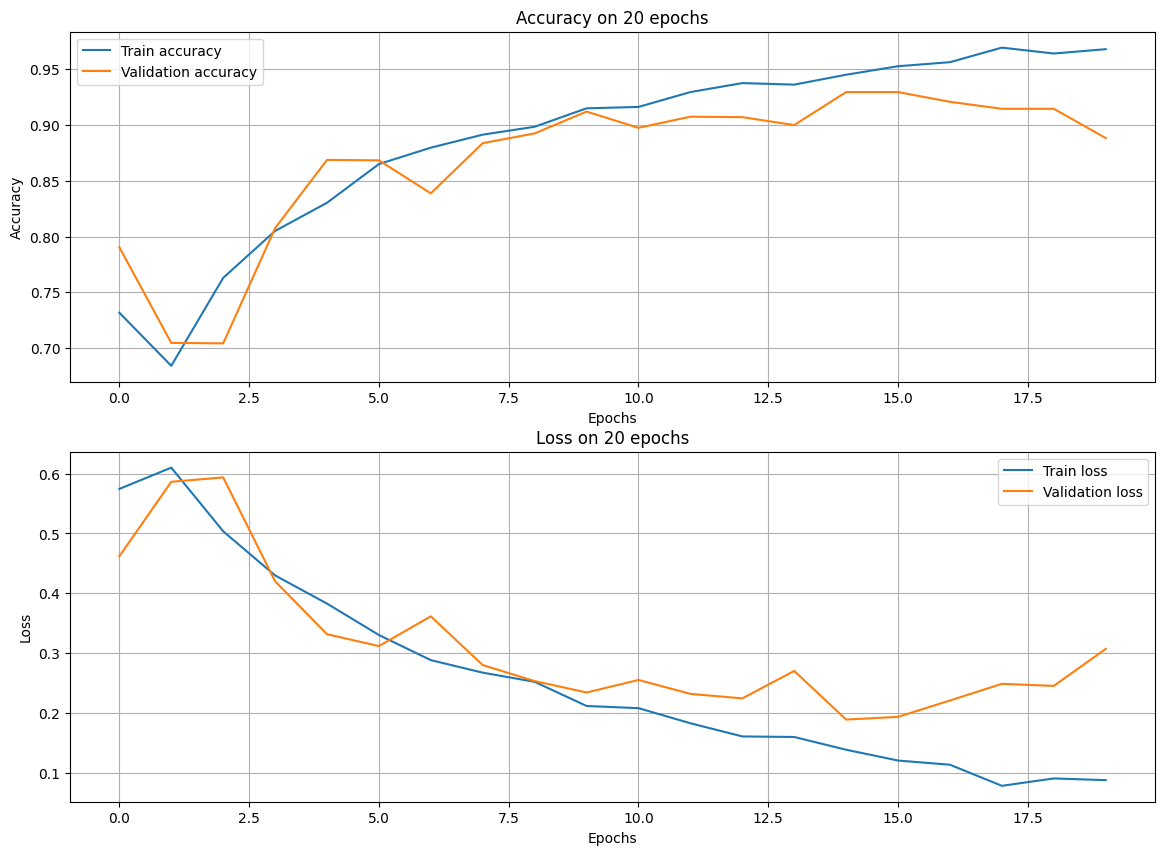

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(np.arange(20), train_acc, label="Train accuracy")
ax1.plot(np.arange(20), val_acc, label="Validation accuracy")
ax2.plot(np.arange(20), train_loss, label="Train loss")
ax2.plot(np.arange(20), val_loss, label="Validation loss")

ax1.set_title("Accuracy on 20 epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

ax2.set_title("Loss on 20 epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.show()

In [122]:
test_acc, test_loss, cm, report = test(model, test_dataloader, criterion)

print(f"\nTest accuracy: {test_acc:.4f}")
print(f"\nTest loss: {test_loss:.4f}")
print(f"\nReport:\n{report}")


Test accuracy: 0.9012

Test loss: 0.3030

Report:
              precision    recall  f1-score   support

           0     0.8669    0.9547    0.9087      1235
           1     0.9462    0.8446    0.8925      1165

    accuracy                         0.9012      2400
   macro avg     0.9065    0.8996    0.9006      2400
weighted avg     0.9054    0.9012    0.9008      2400



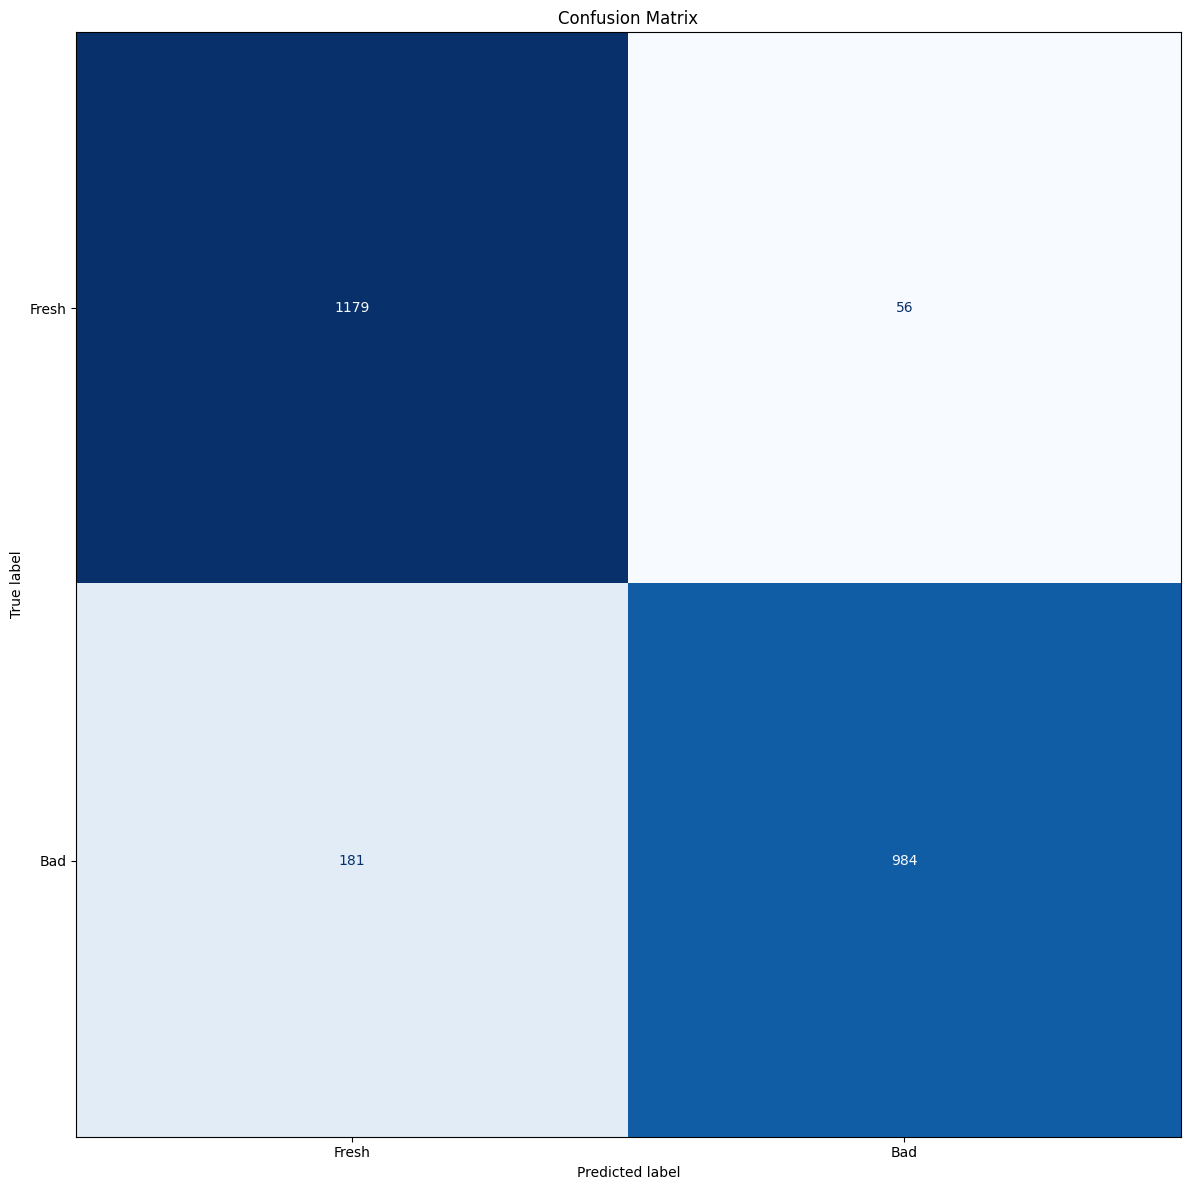

In [123]:
fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=FOOD_CLASSES)
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Confusion Matrix")

plt.tight_layout()
plt.show()